In [148]:
# Instalar bibliotecas para embeddings e modelo
!pip install sentence-transformers xgboost

In [149]:
# Bibliotecas principais
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn para treino e métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Embeddings via modelo pré-treinado
from sentence_transformers import SentenceTransformer

# Classificador baseado em árvores
from xgboost import XGBClassifier

In [150]:
# Caminho para o arquivo com dados pré-processados e features jurídicas
caminho_arquivo = "C:\\Users\\willgnnerferreira\\Documents\\Modelos\\Perfil-Conciliação\\Dados\\dados_processos_cejusc_features.json"

# Função para carregar cada linha como um dicionário
def carregar_dados(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        dados = [json.loads(linha) for linha in f]
    return pd.DataFrame(dados)

# Carregando o DataFrame
df = carregar_dados(caminho_arquivo)
print("Exemplo de dados:")
display(df.head())

Exemplo de dados:


,numero_processo,comarca,serventia,assunto,classe,polo_ativo,polo_passivo,cpf_cnpj_polo_ativo,cpf_cnpj_polo_passivo,inteiro_teor,...,tem_execucao,tem_acordo,tem_dano_moral,tem_protesto,tem_penhora,tem_repeticao_indebito,tem_inexistencia_relacao,tem_valor_monetario,n_artigos_lei,n_tokens_chave
0,5437274.43.2024.8.09.0012,APARECIDA DE GOIÂNIA,Aparecida de Goiânia - 2º Juizado Especial Cível,DIREITO CIVIL -> Obrigações -> Espécies de Con...,PROCESSO CÍVEL E DO TRABALHO -> Processo de Ex...,Lygia Crysthina Athaide Leite,Paulo Cesar Ribeiro De Oliveira,2132932506,11915791740,AO JUIZO DO JUIZADO ESPECIAL CIVEL DA COMARCA ...,...,1,1,0,1,1,0,0,1,11,10
1,5437284.21.2024.8.09.0131,PORANGATU,Porangatu - Juizado Especial Cível,DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DI...,PROCESSO CÍVEL E DO TRABALHO -> Processo de Co...,Vilmar Alves Da Silva,Banco Itau Consignado Sa,24219452168,33885724000119,"Rua [REMOVIDO], nº 23, Qd. 18, Lt. 08, Centro,...",...,0,0,0,0,0,0,0,0,0,0
2,5438477.44.2024.8.09.0140,SANCLERLÂNDIA,Sanclerlândia - Vara de Família e Sucessões,DIREITO PROCESSUAL CIVIL E DO TRABALHO -> Liqu...,PROCESSO CÍVEL E DO TRABALHO -> Processo de Co...,Ana Queren Rpdrigues Cordeiro,Emerson Cordeiro Silva,11181129117,75288915172,ADVOCACIA CENTRAL de Sanclerlândia Dr. Clodomi...,...,0,0,0,0,0,0,0,0,0,0
3,5437321.31.2024.8.09.0169,ÁGUAS LINDAS DE GOIÁS,Águas Lindas de Goiás - Juizado Especial Cível,DIREITO PROCESSUAL CIVIL E DO TRABALHO -> Juri...,PROCESSO CÍVEL E DO TRABALHO -> Outros Procedi...,Arion Candeia Da Silva,Isaque Teixeira De Menezes,38651432100,4919347189,AO JUÍZO DO JUIZADO ESPECIAL CÍVEL DA COMARCA ...,...,1,0,0,0,0,0,0,1,7,3
4,5438510.45.2024.8.09.0007,ANÁPOLIS,Anápolis - 4º Juizado Especial Cível,DIREITO DO CONSUMIDOR -> Contratos de Consumo ...,PROCESSO CÍVEL E DO TRABALHO -> Processo de Co...,Vera Lucia Vieira Cardoso,Banco Mercantil Do Brasil Sa,60151412120,17184037000110,Dr. Tiziano Mamede Chiarotti,...,0,0,0,0,0,0,0,0,0,0


In [151]:
# Mapeia os rótulos de classe para valores binários e cria colunas auxiliares simples
def preprocessar(df):
    df = df.copy()
    df['classificacao'] = df['classificacao'].map({'frutifero': 1, 'infrutifero': 0})
    df["n_palavras"] = df["inteiro_teor"].str.split().apply(len)
    df["tem_execucao"] = df["inteiro_teor"].str.contains("execução", case=False, na=False).astype(int)
    df["tem_acordo"] = df["inteiro_teor"].str.contains("acordo", case=False, na=False).astype(int)
    return df

# Aplica o pré-processamento
df = preprocessar(df)

In [152]:
# Carrega o modelo de embeddings multilingue leve
modelo_embedding = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# Aplica embeddings ao campo 'inteiro_teor'
vetores_texto = modelo_embedding.encode(df["inteiro_teor"].fillna("").tolist(), show_progress_bar=True)

Batches:   0%|          | 0/519 [00:00<?, ?it/s]

In [153]:
import os
import numpy as np

# Caminho completo onde os embeddings serão salvos
caminho_embeddings = "C:\\Users\\willgnnerferreira\\Documents\\Modelos\\Perfil-Conciliação\\Dados\\Embeddings\\vetores_texto.npy"

# Vai garantir que o diretório existe
os.makedirs(os.path.dirname(caminho_embeddings), exist_ok=True)

# Vai salavar os vetores em formato binário
np.save(caminho_embeddings, vetores_texto)
print(f"Embeddings salvos com sucesso em: {caminho_embeddings}")

Embeddings salvos com sucesso em: C:\Users\willgnnerferreira\Documents\Modelos\Perfil-Conciliação\Dados\Embeddings\vetores_texto.npy


In [154]:
# Seleciona todas as colunas de features jurídicas estruturadas
colunas_struct = [col for col in df.columns if col.startswith("tem_") or col.startswith("n_")]

# Converte essas colunas em array NumPy
X_estruturado = df[colunas_struct].values

# Junta os vetores de texto com as features estruturadas
X_final = np.hstack((vetores_texto, X_estruturado))

# Define a variável alvo (classificação binária)
y = df["classificacao"].values

In [155]:
# Mostra as colunas auxiliares usadas como entrada do modelo
print("Features estruturadas usadas:", colunas_struct)

Features estruturadas usadas: ['tem_execucao', 'tem_acordo', 'tem_dano_moral', 'tem_protesto', 'tem_penhora', 'tem_repeticao_indebito', 'tem_inexistencia_relacao', 'tem_valor_monetario', 'n_artigos_lei', 'n_tokens_chave', 'n_palavras']


In [156]:
# Divide os dados em treino e teste, mantendo a proporção das classes (stratify)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, stratify=y, test_size=0.2, random_state=42)

# Cria o classificador XGBoost
clf = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, eval_metric='logloss')

# Treina o modelo
clf.fit(X_train, y_train)

# Realiza a predição
y_pred = clf.predict(X_test)

# Exibe as métricas de avaliação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1785
           1       0.65      0.61      0.63      1532

    accuracy                           0.67      3317
   macro avg       0.66      0.66      0.66      3317
weighted avg       0.66      0.67      0.66      3317



In [157]:
import joblib

# Caminho para salvar
caminho_modelo = "C:\\Users\\willgnnerferreira\\Documents\\Modelos\\Perfil-Conciliação\\App\\modelo_xgboost.pkl"
joblib.dump(clf, caminho_modelo)
print("Modelo salvo com sucesso em:", caminho_modelo)

Modelo salvo com sucesso em: C:\Users\willgnnerferreira\Documents\Modelos\Perfil-Conciliação\App\modelo_xgboost.pkl


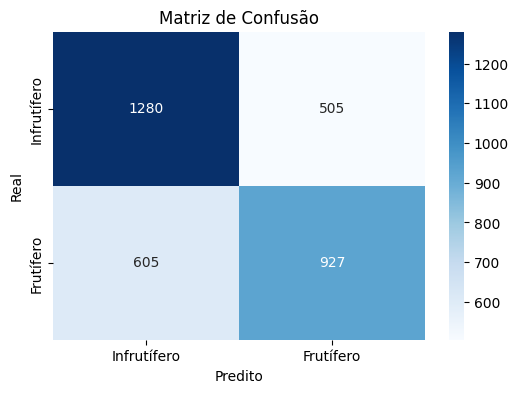

In [158]:
# Exibe uma matriz de confusão com visualização
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Infrutífero", "Frutífero"], yticklabels=["Infrutífero", "Frutífero"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

In [ ]:
# Recebe nova petição, extrai embeddings e features estruturadas, e retorna predição e explicação

def prever_nova_peticao(peticao):
    texto = peticao.strip()
    texto_lower = texto.lower()
    emb = modelo_embedding.encode([texto])

    features_extraidas = []
    motivos = []

    for col in colunas_struct:
        if col.startswith("tem_"):
            termo = col.replace("tem_", "").replace("_", " ")
            valor = int(termo in texto_lower)
            if valor == 1:
                motivos.append(f"menção a '{termo}'")
        elif col == "n_palavras":
            valor = len(texto.split())
            if valor < 150:
                motivos.append("poucas palavras no texto")
            elif valor > 500:
                motivos.append("petição longa com muitos detalhes")
        elif col == "n_artigos_lei":
            valor = texto_lower.count("art. ")
            if valor > 3:
                motivos.append("diversos artigos legais mencionados")
        elif col == "n_tokens_chave":
            tokens_chave = ["execução", "inadimplemento", "acordo", "protesto", "quitação", "extrajudicial"]
            valor = sum([texto_lower.count(tok) for tok in tokens_chave])
            if valor > 2:
                motivos.append("uso intensivo de termos jurídicos relevantes")
        else:
            valor = 0
        features_extraidas.append(valor)

    X = np.hstack((emb, [features_extraidas]))
    pred = clf.predict(X)[0]

    classe = "Frutífera" if pred == 1 else "Infrutífera"
    explicacao = f"<strong>Classificado como {classe}.</strong>"

    if motivos:
        explicacao += "<br><em>Principais indícios:</em> " + "; ".join(motivos) + "."

    return explicacao

In [168]:
# Teste com nova petição 
nova_peticao = {
    "inteiro_teor": """demonstrativo dos debitos originais processos da divida ativa processo: ..."""
}

# Chama a função de predição
explicacao = prever_nova_peticao(nova_peticao["inteiro_teor"])

# Mostra a explicação da decisão
print(explicacao)

<strong>Classificado como Infrutífera.</strong><br><em>Principais indícios:</em> poucas palavras no texto.


Testando o modelo

In [ ]:
# Caminho do arquivo JSON contendo petições com features estruturadas
caminho = "C:\\Users\\willgnnerferreira\\Documents\\Modelos\\Perfil-Conciliação\\Dados\\dados_processos_cejusc_features.json"

# Carregamento linha a linha (formato JSONL) e conversão para DataFrame
with open(caminho, 'r', encoding='utf-8') as f:
    dados_json = [json.loads(linha) for linha in f]

df_real = pd.DataFrame(dados_json)
print("Exemplo de dados:")
display(df_real.head())

Exemplo de dados:


,numero_processo,comarca,serventia,assunto,classe,polo_ativo,polo_passivo,cpf_cnpj_polo_ativo,cpf_cnpj_polo_passivo,inteiro_teor,...,tem_execucao,tem_acordo,tem_dano_moral,tem_protesto,tem_penhora,tem_repeticao_indebito,tem_inexistencia_relacao,tem_valor_monetario,n_artigos_lei,n_tokens_chave
0,5437274.43.2024.8.09.0012,APARECIDA DE GOIÂNIA,Aparecida de Goiânia - 2º Juizado Especial Cível,DIREITO CIVIL -> Obrigações -> Espécies de Con...,PROCESSO CÍVEL E DO TRABALHO -> Processo de Ex...,Lygia Crysthina Athaide Leite,Paulo Cesar Ribeiro De Oliveira,2132932506,11915791740,AO JUIZO DO JUIZADO ESPECIAL CIVEL DA COMARCA ...,...,1,1,0,1,1,0,0,1,11,10
1,5437284.21.2024.8.09.0131,PORANGATU,Porangatu - Juizado Especial Cível,DIREITO ADMINISTRATIVO E OUTRAS MATÉRIAS DE DI...,PROCESSO CÍVEL E DO TRABALHO -> Processo de Co...,Vilmar Alves Da Silva,Banco Itau Consignado Sa,24219452168,33885724000119,"Rua [REMOVIDO], nº 23, Qd. 18, Lt. 08, Centro,...",...,0,0,0,0,0,0,0,0,0,0
2,5438477.44.2024.8.09.0140,SANCLERLÂNDIA,Sanclerlândia - Vara de Família e Sucessões,DIREITO PROCESSUAL CIVIL E DO TRABALHO -> Liqu...,PROCESSO CÍVEL E DO TRABALHO -> Processo de Co...,Ana Queren Rpdrigues Cordeiro,Emerson Cordeiro Silva,11181129117,75288915172,ADVOCACIA CENTRAL de Sanclerlândia Dr. Clodomi...,...,0,0,0,0,0,0,0,0,0,0
3,5437321.31.2024.8.09.0169,ÁGUAS LINDAS DE GOIÁS,Águas Lindas de Goiás - Juizado Especial Cível,DIREITO PROCESSUAL CIVIL E DO TRABALHO -> Juri...,PROCESSO CÍVEL E DO TRABALHO -> Outros Procedi...,Arion Candeia Da Silva,Isaque Teixeira De Menezes,38651432100,4919347189,AO JUÍZO DO JUIZADO ESPECIAL CÍVEL DA COMARCA ...,...,1,0,0,0,0,0,0,1,7,3
4,5438510.45.2024.8.09.0007,ANÁPOLIS,Anápolis - 4º Juizado Especial Cível,DIREITO DO CONSUMIDOR -> Contratos de Consumo ...,PROCESSO CÍVEL E DO TRABALHO -> Processo de Co...,Vera Lucia Vieira Cardoso,Banco Mercantil Do Brasil Sa,60151412120,17184037000110,Dr. Tiziano Mamede Chiarotti,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Se a coluna 'n_palavras' não estiver no dataset, cria novamente
df_real["n_palavras"] = df_real["inteiro_teor"].str.split().apply(len)

In [ ]:
# Identifica todas as features que começam com 'tem_' ou 'n_'
colunas_struct = [col for col in df_real.columns if col.startswith("tem_") or col.startswith("n_")]

# Geração dos embeddings dos textos
vetores_texto_real = modelo_embedding.encode(df_real["inteiro_teor"].fillna("").tolist(), show_progress_bar=True)

# Pega as colunas estruturadas como array
X_estruturado_real = df_real[colunas_struct].values

# Concatena embeddings com features estruturadas
X_real = np.hstack((vetores_texto_real, X_estruturado_real))

# Extrai os rótulos reais do dataset para avaliação posterior
y_real = df_real["classificacao"].map({'frutifero': 1, 'infrutifero': 0}).values

Batches:   0%|          | 0/519 [00:00<?, ?it/s]

In [ ]:
# Compara a dimensão esperada pelo modelo com os dados reais (X_real)
print("Esperado pelo modelo:", X_train.shape[1])
print("Shape de X_real:", X_real.shape[1])

Esperado pelo modelo: 395
Shape de X_real: 395


In [ ]:
# Predição sobre os dados reais (sem usar a classificação original)
y_pred_real = clf.predict(X_real)

In [ ]:
from sklearn.metrics import accuracy_score

# Mapeamento legível dos labels
mapa_label = {0: "Infrutífero", 1: "Frutífero"}

acertos = 0
total = len(df_real)

# Imprime comparação por linha com status
for i in range(total):
    real = y_real[i]
    pred = y_pred_real[i]
    status = "ACERTOU" if real == pred else "ERROU"
    
    print(f"{i+1:03d} | Real: {mapa_label[real]:12} | Predito: {mapa_label[pred]:12} | {status}")
    if real == pred:
        acertos += 1

# Mostra o desempenho geral
print("\nRESUMO FINAL")
print(f"Acertos: {acertos}/{total}")
print(f"Acurácia: {acertos / total:.2%}")

001 | Real: Frutífero    | Predito: Frutífero    | ACERTOU
002 | Real: Infrutífero  | Predito: Infrutífero  | ACERTOU
003 | Real: Frutífero    | Predito: Infrutífero  | ERROU
004 | Real: Infrutífero  | Predito: Infrutífero  | ACERTOU
005 | Real: Infrutífero  | Predito: Infrutífero  | ACERTOU
006 | Real: Frutífero    | Predito: Frutífero    | ACERTOU
007 | Real: Frutífero    | Predito: Frutífero    | ACERTOU
008 | Real: Frutífero    | Predito: Frutífero    | ACERTOU
009 | Real: Infrutífero  | Predito: Infrutífero  | ACERTOU
010 | Real: Infrutífero  | Predito: Infrutífero  | ACERTOU
011 | Real: Frutífero    | Predito: Infrutífero  | ERROU
012 | Real: Frutífero    | Predito: Frutífero    | ACERTOU
013 | Real: Infrutífero  | Predito: Infrutífero  | ACERTOU
014 | Real: Infrutífero  | Predito: Infrutífero  | ACERTOU
015 | Real: Frutífero    | Predito: Frutífero    | ACERTOU
016 | Real: Frutífero    | Predito: Frutífero    | ACERTOU
017 | Real: Infrutífero  | Predito: Infrutífero  | ACERTOU
0

In [ ]:
# Mede o tempo total de inferência sobre o dataset real
import time

start = time.time()
y_pred_real = clf.predict(X_real)
end = time.time()

print(f"Tempo de inferência: {end - start:.4f} segundos")

Tempo de inferência: 0.0220 segundos


In [ ]:
# Avaliação quantitativa das predições (sem usar labels como entrada)
print("Avaliação na base real (sem usar classificação como entrada):")
print(classification_report(y_real, y_pred_real, target_names=["Infrutífero", "Frutífero"]))

Avaliação na base real (sem usar classificação como entrada):
              precision    recall  f1-score   support

 Infrutífero       0.89      0.87      0.88      8924
   Frutífero       0.86      0.87      0.86      7659

    accuracy                           0.87     16583
   macro avg       0.87      0.87      0.87     16583
weighted avg       0.87      0.87      0.87     16583



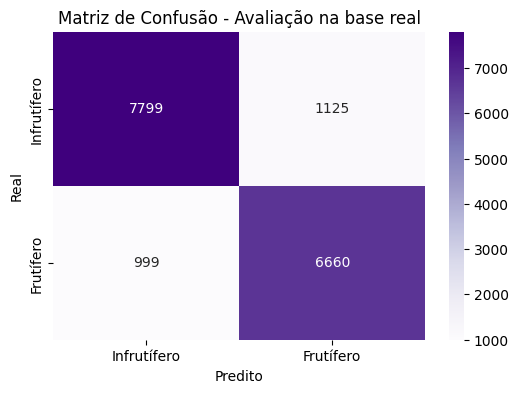

In [ ]:
# Matriz de confusão mostrando erros entre classes
cm = confusion_matrix(y_real, y_pred_real)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=["Infrutífero", "Frutífero"], yticklabels=["Infrutífero", "Frutífero"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Avaliação na base real")
plt.show()

In [1]:
pip list

Package                 Version
----------------------- -----------
asttokens               3.0.0
colorama                0.4.6
comm                    0.2.2
debugpy                 1.8.14
decorator               5.2.1
executing               2.2.0
ipykernel               6.29.5
ipython                 9.3.0
ipython_pygments_lexers 1.1.1
jedi                    0.19.2
jupyter_client          8.6.3
jupyter_core            5.8.1
matplotlib-inline       0.1.7
nest-asyncio            1.6.0
packaging               25.0
parso                   0.8.4
pip                     24.3.1
platformdirs            4.3.8
prompt_toolkit          3.0.51
psutil                  7.0.0
pure_eval               0.2.3
Pygments                2.19.1
python-dateutil         2.9.0.post0
pywin32                 310
pyzmq                   26.4.0
six                     1.17.0
stack-data              0.6.3
tornado                 6.5.1
traitlets               5.14.3
wcwidth                 0.2.13
Note: you may need 